In [1]:
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler 
from timeit import timeit

In [2]:
days = 3
in_days = 5

offset = round(days*24)# hours
inputs = round(in_days*24)
feat_scaler = MinMaxScaler((-1, 1))
target_scaler = MinMaxScaler((-1, 1))
targets = ['V']

The following cell defines the function used to tabulate time series data so it can be used by ElasticNet to perform autoregression. The tabulation process is trivial: new columns are added to the dataset containing data offset by a certain amount, and the total number of entries is reduced by the maximum offset.

In [3]:
def tabulate_series(df, freq='1h', inputs=1, offset=1, second_offset = None):
    src = df.copy().shift(offset+inputs)
    new_c = src.columns.values.copy()
    for i in range(len(new_c)):
        new_c[i] = new_c[i]+f'-{offset+inputs}'
    src.columns = new_c
    for i in range(offset+inputs-1, offset-1, -1):
        new_df = df.shift(i, freq=freq)
        new_c = new_df.columns.values.copy()
        new_df.columns = new_c
        for j in range(len(new_c)):
            new_c[j] = new_c[j]+f'-{i}'
        src = src.join(new_df)
    if second_offset:
        for i in range(second_offset+inputs-1, second_offset-1, -1):
            new_df = df.shift(i, freq=freq)
            new_c = new_df.columns.values.copy()
            new_df.columns = new_c
            for j in range(len(new_c)):
                new_c[j] = new_c[j]+f'-{i}'
            src = src.join(new_df)
    return src.join(df).dropna(how='any')

Load the validation info used for the experiment.

In [4]:
val_info = pd.read_csv('data/SW_validation_info.csv', sep=';')[['Start date', 'End date']]
val_info = val_info[len(val_info)//2:]
val_info

,Start date,End date
1,01/01/2017,01/01/2018


Load and structure the dataset used. First, load wind and CH data, and unpack the latter for usage.

In [5]:
wind_data = pd.read_csv('data/omni_1hr_clean.csv', index_col=0, parse_dates=[0])
wind_data['T'] = wind_data['T'].apply(np.log10)
wind_data = wind_data[wind_data.index >= '2011-01-01']
wind_data = wind_data[wind_data.index < '2018-01-01']
display(wind_data)
new_idx = pd.date_range(wind_data.index[0], wind_data.index[-1], freq='1h')
wind_data = wind_data.reindex(new_idx, fill_value=np.nan)
wind_data = wind_data.interpolate(method='time').rolling(rolling_window, center=centered).mean()
wind_data

,BR,BT,BN,V,N,T
datetime,,,,,,
2011-01-01 00:00:00,2.3,-3.2,-1.5,326.0,3.900000,4.592931
2011-01-01 01:00:00,1.5,-3.0,0.7,335.0,4.400000,4.541242
2011-01-01 02:00:00,2.3,-3.3,0.7,330.0,4.000000,4.391588
2011-01-01 03:00:00,1.0,-1.4,0.6,341.0,5.900000,4.532181
2011-01-01 04:00:00,1.4,-2.2,-1.0,341.0,7.100000,4.514056
...,...,...,...,...,...,...
2017-12-31 19:00:00,0.3,-3.6,2.4,358.0,29.700001,4.428005
2017-12-31 20:00:00,2.8,-6.5,-2.2,370.0,17.000000,4.830422
2017-12-31 21:00:00,4.2,-6.9,-6.1,363.0,10.900000,4.784161


,BR,BT,BN,V,N,T
2011-01-01 00:00:00,2.3,-3.2,-1.5,326.0,3.900000,4.592931
2011-01-01 01:00:00,1.5,-3.0,0.7,335.0,4.400000,4.541242
2011-01-01 02:00:00,2.3,-3.3,0.7,330.0,4.000000,4.391588
2011-01-01 03:00:00,1.0,-1.4,0.6,341.0,5.900000,4.532181
2011-01-01 04:00:00,1.4,-2.2,-1.0,341.0,7.100000,4.514056
...,...,...,...,...,...,...
2017-12-31 19:00:00,0.3,-3.6,2.4,358.0,29.700001,4.428005
2017-12-31 20:00:00,2.8,-6.5,-2.2,370.0,17.000000,4.830422
2017-12-31 21:00:00,4.2,-6.9,-6.1,363.0,10.900000,4.784161
2017-12-31 22:00:00,3.9,-7.8,-4.5,363.0,8.200000,4.863162


In [23]:
combined=wind_data
combined = combined[offset:].copy()
combined

,BR,BT,BN,V,N,T
2011-01-04 00:00:00,-0.2,-7.2,-0.2,384.0,8.100000,5.044520
2011-01-04 01:00:00,2.7,-5.5,-0.8,393.0,8.800000,5.073396
2011-01-04 02:00:00,1.0,-3.0,1.2,401.0,10.600000,5.113519
2011-01-04 03:00:00,2.4,-0.5,-3.8,399.0,9.200000,5.055841
2011-01-04 04:00:00,2.0,-3.4,-0.5,404.0,7.500000,5.023112
...,...,...,...,...,...,...
2017-12-31 19:00:00,0.3,-3.6,2.4,358.0,29.700001,4.428005
2017-12-31 20:00:00,2.8,-6.5,-2.2,370.0,17.000000,4.830422
2017-12-31 21:00:00,4.2,-6.9,-6.1,363.0,10.900000,4.784161
2017-12-31 22:00:00,3.9,-7.8,-4.5,363.0,8.200000,4.863162


Tabulate the data for usage.

In [26]:
tabulated = tabulate_series(combined, inputs=inputs, offset=offset, second_offset=24*24)
tabulated

,BR-192,BT-192,BN-192,V-192,N-192,T-192,BR-191,BT-191,BN-191,V-191,...,BN-576,V-576,N-576,T-576,BR,BT,BN,V,N,T
2011-02-01 23:00:00,6.4,-0.7,-2.7,357.0,6.1,4.306532,5.8,-0.2,-2.8,352.0,...,-0.4,614.0,1.5,5.245152,-0.4,1.7,0.7,525.0,3.900000,5.198962
2011-02-02 00:00:00,5.8,-0.2,-2.8,352.0,7.4,4.353647,5.5,-1.0,-2.9,363.0,...,0.8,572.0,1.1,5.101524,-2.3,2.0,0.1,512.0,3.900000,5.210875
2011-02-02 01:00:00,5.5,-1.0,-2.9,363.0,7.5,4.251687,5.9,-1.9,-3.3,363.0,...,0.5,576.0,1.5,5.108034,-3.4,1.6,0.5,499.0,4.200000,5.263608
2011-02-02 02:00:00,5.9,-1.9,-3.3,363.0,5.9,4.241048,4.9,-2.8,-3.4,355.0,...,0.0,562.0,1.9,5.093807,-4.2,1.3,1.4,489.0,4.500000,5.141491
2011-02-02 03:00:00,4.9,-2.8,-3.4,355.0,6.8,4.206448,4.2,-3.0,-3.8,348.0,...,0.5,551.0,1.9,5.167066,-4.1,1.2,1.4,486.0,4.400000,5.108568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,-0.8,3.0,4.4,349.0,11.6,4.792153,-2.3,3.7,-0.4,346.0,...,-0.6,503.0,3.3,4.957454,0.3,-3.6,2.4,358.0,29.700001,4.428005
2017-12-31 20:00:00,-2.3,3.7,-0.4,346.0,11.1,4.789877,-0.4,4.6,4.9,353.0,...,-1.3,495.0,3.1,4.967585,2.8,-6.5,-2.2,370.0,17.000000,4.830422
2017-12-31 21:00:00,-0.4,4.6,4.9,353.0,10.2,4.696671,-2.1,4.7,3.2,348.0,...,-1.0,498.0,3.2,4.942757,4.2,-6.9,-6.1,363.0,10.900000,4.784161
2017-12-31 22:00:00,-2.1,4.7,3.2,348.0,10.6,4.747691,-0.7,5.8,4.5,353.0,...,-1.5,491.0,2.6,4.951852,3.9,-7.8,-4.5,363.0,8.200000,4.863162


### Dataset split

The following section removes unwanted features (for example, for an ablation study), and splits the dataset between training and testing sets to allow for generalization to be verified.

In [27]:
from sklearn.linear_model import *
from sklearn.svm import *

In [28]:
exclude = ['BR', 'BT', 'BN', 'N', 'T'] # Measurements other than the input that must be excluded.
                                       # The lack of a number in the name indicates that they are the measurement at the time 
                                       # t, aligned with the forecasting target.

In [29]:
inputs = tabulated.columns.values.tolist()
# very dirty exception handling, but we know there will only be
# exceptions here if the column doesn't exist, so we can just
# skip any that are like that and keep going until we're done with the
# entire list
for o in targets:
    try:
        inputs.remove(o)
    except:
        continue
for o in exclude:
    try:
        inputs.remove(o)
    except:
        continue
inputs

['BR-192',
 'BT-192',
 'BN-192',
 'V-192',
 'N-192',
 'T-192',
 'BR-191',
 'BT-191',
 'BN-191',
 'V-191',
 'N-191',
 'T-191',
 'BR-190',
 'BT-190',
 'BN-190',
 'V-190',
 'N-190',
 'T-190',
 'BR-189',
 'BT-189',
 'BN-189',
 'V-189',
 'N-189',
 'T-189',
 'BR-188',
 'BT-188',
 'BN-188',
 'V-188',
 'N-188',
 'T-188',
 'BR-187',
 'BT-187',
 'BN-187',
 'V-187',
 'N-187',
 'T-187',
 'BR-186',
 'BT-186',
 'BN-186',
 'V-186',
 'N-186',
 'T-186',
 'BR-185',
 'BT-185',
 'BN-185',
 'V-185',
 'N-185',
 'T-185',
 'BR-184',
 'BT-184',
 'BN-184',
 'V-184',
 'N-184',
 'T-184',
 'BR-183',
 'BT-183',
 'BN-183',
 'V-183',
 'N-183',
 'T-183',
 'BR-182',
 'BT-182',
 'BN-182',
 'V-182',
 'N-182',
 'T-182',
 'BR-181',
 'BT-181',
 'BN-181',
 'V-181',
 'N-181',
 'T-181',
 'BR-180',
 'BT-180',
 'BN-180',
 'V-180',
 'N-180',
 'T-180',
 'BR-179',
 'BT-179',
 'BN-179',
 'V-179',
 'N-179',
 'T-179',
 'BR-178',
 'BT-178',
 'BN-178',
 'V-178',
 'N-178',
 'T-178',
 'BR-177',
 'BT-177',
 'BN-177',
 'V-177',
 'N-177',
 '

In [30]:
input_df = tabulated[inputs]
output_df = tabulated[targets]
output_df = output_df[output_df.index >= input_df.index[0]]
input_df = input_df[input_df.index <= output_df.index[-1]]

In [31]:
input_df

,BR-192,BT-192,BN-192,V-192,N-192,T-192,BR-191,BT-191,BN-191,V-191,...,BN-577,V-577,N-577,T-577,BR-576,BT-576,BN-576,V-576,N-576,T-576
2011-02-01 23:00:00,6.4,-0.7,-2.7,357.0,6.1,4.306532,5.8,-0.2,-2.8,352.0,...,0.9,617.0,1.7,5.213574,-1.0,-2.3,-0.4,614.0,1.5,5.245152
2011-02-02 00:00:00,5.8,-0.2,-2.8,352.0,7.4,4.353647,5.5,-1.0,-2.9,363.0,...,-0.4,614.0,1.5,5.245152,-2.0,0.2,0.8,572.0,1.1,5.101524
2011-02-02 01:00:00,5.5,-1.0,-2.9,363.0,7.5,4.251687,5.9,-1.9,-3.3,363.0,...,0.8,572.0,1.1,5.101524,-2.3,-0.1,0.5,576.0,1.5,5.108034
2011-02-02 02:00:00,5.9,-1.9,-3.3,363.0,5.9,4.241048,4.9,-2.8,-3.4,355.0,...,0.5,576.0,1.5,5.108034,-1.8,-1.2,0.0,562.0,1.9,5.093807
2011-02-02 03:00:00,4.9,-2.8,-3.4,355.0,6.8,4.206448,4.2,-3.0,-3.8,348.0,...,0.0,562.0,1.9,5.093807,-3.1,-0.7,0.5,551.0,1.9,5.167066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,-0.8,3.0,4.4,349.0,11.6,4.792153,-2.3,3.7,-0.4,346.0,...,-0.5,509.0,3.2,4.991833,1.9,-2.4,-0.6,503.0,3.3,4.957454
2017-12-31 20:00:00,-2.3,3.7,-0.4,346.0,11.1,4.789877,-0.4,4.6,4.9,353.0,...,-0.6,503.0,3.3,4.957454,1.3,-1.8,-1.3,495.0,3.1,4.967585
2017-12-31 21:00:00,-0.4,4.6,4.9,353.0,10.2,4.696671,-2.1,4.7,3.2,348.0,...,-1.3,495.0,3.1,4.967585,1.3,-0.4,-1.0,498.0,3.2,4.942757
2017-12-31 22:00:00,-2.1,4.7,3.2,348.0,10.6,4.747691,-0.7,5.8,4.5,353.0,...,-1.0,498.0,3.2,4.942757,1.5,0.9,-1.5,491.0,2.6,4.951852


In [32]:
output_df

,V
2011-02-01 23:00:00,525.0
2011-02-02 00:00:00,512.0
2011-02-02 01:00:00,499.0
2011-02-02 02:00:00,489.0
2011-02-02 03:00:00,486.0
...,...
2017-12-31 19:00:00,358.0
2017-12-31 20:00:00,370.0
2017-12-31 21:00:00,363.0
2017-12-31 22:00:00,363.0


In [33]:
test_data_in = []
test_data_out = []
for row in val_info.values:
    start = row[0]
    end = row[1]
    new_df_in = input_df[input_df.index >= start].copy()
    new_df_in = new_df_in[new_df_in.index <= end].copy()
    new_df_out = output_df[input_df.index >= start].copy()
    new_df_out = new_df_out[new_df_out.index <= end].copy()
    test_data_in.append(new_df_in)
    test_data_out.append(new_df_out)
X_test = pd.concat(test_data_in)
y_test = pd.concat(test_data_out)
X_train = input_df[~input_df.index.isin(y_test.index)].copy()
y_train = output_df[~output_df.index.isin(X_test.index)].copy()

display(X_train)
display(y_train)
display(X_test)
display(y_test)

,BR-192,BT-192,BN-192,V-192,N-192,T-192,BR-191,BT-191,BN-191,V-191,...,BN-577,V-577,N-577,T-577,BR-576,BT-576,BN-576,V-576,N-576,T-576
2011-02-01 23:00:00,6.4,-0.7,-2.7,357.0,6.1,4.306532,5.8,-0.2,-2.8,352.0,...,0.9,617.0,1.700000,5.213574,-1.0,-2.3,-0.4,614.0,1.5,5.245152
2011-02-02 00:00:00,5.8,-0.2,-2.8,352.0,7.4,4.353647,5.5,-1.0,-2.9,363.0,...,-0.4,614.0,1.500000,5.245152,-2.0,0.2,0.8,572.0,1.1,5.101524
2011-02-02 01:00:00,5.5,-1.0,-2.9,363.0,7.5,4.251687,5.9,-1.9,-3.3,363.0,...,0.8,572.0,1.100000,5.101524,-2.3,-0.1,0.5,576.0,1.5,5.108034
2011-02-02 02:00:00,5.9,-1.9,-3.3,363.0,5.9,4.241048,4.9,-2.8,-3.4,355.0,...,0.5,576.0,1.500000,5.108034,-1.8,-1.2,0.0,562.0,1.9,5.093807
2011-02-02 03:00:00,4.9,-2.8,-3.4,355.0,6.8,4.206448,4.2,-3.0,-3.8,348.0,...,0.0,562.0,1.900000,5.093807,-3.1,-0.7,0.5,551.0,1.9,5.167066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,0.9,-3.3,-3.2,714.0,2.1,5.376969,2.0,-1.5,-2.4,699.0,...,-1.7,356.0,35.700001,4.562543,2.9,-1.7,-4.0,369.0,50.0,4.589782
2016-12-31 20:00:00,2.0,-1.5,-2.4,699.0,2.0,5.300036,1.9,-2.9,-0.7,710.0,...,-4.0,369.0,50.000000,4.589782,-9.1,1.5,7.1,440.0,15.8,5.222342
2016-12-31 21:00:00,1.9,-2.9,-0.7,710.0,1.9,5.300295,2.0,-2.9,-0.4,704.0,...,7.1,440.0,15.800000,5.222342,-10.3,9.8,-1.2,472.0,7.8,5.295413
2016-12-31 22:00:00,2.0,-2.9,-0.4,704.0,1.7,5.301948,3.3,-3.5,0.9,687.0,...,-1.2,472.0,7.800000,5.295413,5.6,-2.4,0.8,531.0,10.1,5.604477


,V
2011-02-01 23:00:00,525.0
2011-02-02 00:00:00,512.0
2011-02-02 01:00:00,499.0
2011-02-02 02:00:00,489.0
2011-02-02 03:00:00,486.0
...,...
2016-12-31 19:00:00,498.0
2016-12-31 20:00:00,556.0
2016-12-31 21:00:00,552.0
2016-12-31 22:00:00,549.0


,BR-192,BT-192,BN-192,V-192,N-192,T-192,BR-191,BT-191,BN-191,V-191,...,BN-577,V-577,N-577,T-577,BR-576,BT-576,BN-576,V-576,N-576,T-576
2017-01-01 00:00:00,3.5,-3.3,0.2,648.0,1.6,5.146736,3.6,-3.7,-1.2,638.0,...,-0.1,524.0,8.200000,5.533878,-1.0,2.5,-5.8,494.0,10.700000,5.323996
2017-01-01 01:00:00,3.6,-3.7,-1.2,638.0,1.8,5.194009,3.2,-3.5,0.3,639.0,...,-5.8,494.0,10.700000,5.323996,3.0,-7.3,0.8,475.0,16.600000,5.184265
2017-01-01 02:00:00,3.2,-3.5,0.3,639.0,1.7,5.280842,3.5,-0.6,0.8,654.0,...,0.8,475.0,16.600000,5.184265,4.6,-5.9,0.1,476.0,19.500000,5.154971
2017-01-01 03:00:00,3.5,-0.6,0.8,654.0,1.9,5.376756,3.5,-0.5,1.9,687.0,...,0.1,476.0,19.500000,5.154971,5.0,-2.8,-3.3,483.0,24.799999,5.135924
2017-01-01 04:00:00,3.5,-0.5,1.9,687.0,2.4,5.438799,1.7,-2.6,1.8,687.0,...,-3.3,483.0,24.799999,5.135924,-4.5,-4.9,4.4,472.0,22.200001,5.181386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,-0.8,3.0,4.4,349.0,11.6,4.792153,-2.3,3.7,-0.4,346.0,...,-0.5,509.0,3.200000,4.991833,1.9,-2.4,-0.6,503.0,3.300000,4.957454
2017-12-31 20:00:00,-2.3,3.7,-0.4,346.0,11.1,4.789877,-0.4,4.6,4.9,353.0,...,-0.6,503.0,3.300000,4.957454,1.3,-1.8,-1.3,495.0,3.100000,4.967585
2017-12-31 21:00:00,-0.4,4.6,4.9,353.0,10.2,4.696671,-2.1,4.7,3.2,348.0,...,-1.3,495.0,3.100000,4.967585,1.3,-0.4,-1.0,498.0,3.200000,4.942757
2017-12-31 22:00:00,-2.1,4.7,3.2,348.0,10.6,4.747691,-0.7,5.8,4.5,353.0,...,-1.0,498.0,3.200000,4.942757,1.5,0.9,-1.5,491.0,2.600000,4.951852


,V
2017-01-01 00:00:00,552.0
2017-01-01 01:00:00,556.0
2017-01-01 02:00:00,552.0
2017-01-01 03:00:00,539.0
2017-01-01 04:00:00,543.0
...,...
2017-12-31 19:00:00,358.0
2017-12-31 20:00:00,370.0
2017-12-31 21:00:00,363.0
2017-12-31 22:00:00,363.0


### Model fitting

In [37]:
model = ElasticNetCV(l1_ratio=[i for i in np.arange(0.1, 1.0, .03)], 
                                     verbose=0, 
                                     n_jobs=2)
# model = SVR(kernel='rbf')
%time model.fit(X_train, y_train)

C:\Users\fenix\Anaconda3\envs\manifolds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: total: 53min 45s
Wall time: 14min 15s


ElasticNetCV(l1_ratio=[0.1, 0.13, 0.16, 0.19, 0.22, 0.25, 0.28, 0.31,
                       0.33999999999999997, 0.37, 0.4, 0.42999999999999994,
                       0.45999999999999996, 0.49, 0.52, 0.5499999999999999,
                       0.58, 0.61, 0.64, 0.6699999999999999, 0.7, 0.73,
                       0.7599999999999999, 0.7899999999999999, 0.82, 0.85, 0.88,
                       0.9099999999999999, 0.94, 0.97, ...],
             n_jobs=2)

In [38]:
try:
    print(f'Selected L1 ratio = {model.l1_ratio_}')
except Exception as e:
    print(e)

try:
    print(f'Number of support vectors: {len(model.support_vectors_)}')
    print(f'Shape of support vectors object: {model.support_vectors_.shape}')
    print(f'Support vectors: {model.support_vectors_}')
except:
    pass

Selected L1 ratio = 0.9999999999999999


Obtain the R$^\text{2}$ (coefficient of determination) metric of the model for the test data in the scaled space. As a reminder, 
$$
    \text{R}^\text{2}(y,\hat{y})=1-\frac{(y-\hat{y})^2}{(y-\bar{y})^2}\text{.}
$$

In [39]:
model.score(X_test, y_test)

0.3095122629434892

Display the list of features in the dataset and the assigned coefficients, as well as the intercepts for each output.

In [40]:
model.feature_names_in_

array(['BR-192', 'BT-192', 'BN-192', ..., 'V-576', 'N-576', 'T-576'],
      dtype=object)

In [41]:
try:
    model.coef_
except Exception as e:
    print(e)

In [42]:
try:
    model.intercept_
except Exception as e:
    print(e)

Obtain predictions for the test dataset.

In [43]:
pred = model.predict(X_test)
if len(pred.shape)<2:
    pred = pred.reshape(-1, 1)

In [44]:
pred

array([[364.13179098],
       [365.06554524],
       [365.93120095],
       ...,
       [420.19285703],
       [421.98859841],
       [419.65407075]])

### Numeric evaluation

Evaluate selected performance metrics in the unscaled domain.

In [46]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr

In [48]:
units = {
    'V': 'km/s',
    'T': 'K',
    'N': 'cm^-3',
    'BR': 'nT',
    'BT': 'nT',
    'BN': 'nT',
    'B': 'nT'
}
for i in range(len(targets)):
    if offst > 0:
        print('##############################')
        print(targets[i])
        print('##############################')
        r2 = r2_score(target_scaler.inverse_transform(y_test)[:-offst, i], pred[offst:, i])
        print(f'R2 score:\t\t\t{r2}')
        print(f'RMSE:\t\t\t\t{mean_squared_error(y_test.values[:-offst, i],  pred[offst:, i], squared=False)} {units[targets[i]]}')
        print(f'MAE:\t\t\t\t{mean_absolute_error(y_test.values[:-offst, i], pred[offst:, i])} {units[targets[i]]}')
        pearson, p = pearsonr(y_test.values[offst:, i], 
                              pred[:-offst, i])
        print(f'Pearson correlation:\t\t{pearson}\t|\tp-value:\t{p}')
    else:
        print('##############################')
        print(targets[i])
        print('##############################')
        r2 = r2_score(y_test.values[:, i], pred[:, i])
        print(f'R2 score:\t\t\t{r2}')
        print(f'RMSE:\t\t\t\t{mean_squared_error(y_test.values[:, i],  pred[:, i], squared=False)} {units[targets[i]]}')
        print(f'MAE:\t\t\t\t{mean_absolute_error(y_test.values[:, i], pred[:, i])} {units[targets[i]]}')
        pearson, p = pearsonr(y_test.values[:, i], 
                              pred[:, i])
        print(f'Pearson correlation:\t\t{pearson}\t|\tp-value:\t{p}')

##############################
V
##############################
R2 score:			0.3095122629434892
Adjusted R2 score:		0.30840685090017406
RMSE:				91.09763034844151 km/s
MAE:				72.97214292327783 km/s
MAPE:				15.930477413825491%
SMAPE:				15.837101123098385%
Pearson correlation:		0.5743110604104426	|	p-value:	0.0
Spearman correlation:		0.5738238588960599	|	p-value:	0.0


In [49]:
real = pd.read_csv('data/omni_1hr_clean.csv', index_col=0, parse_dates=[0])
real['T'] = wind_data['T'].apply(np.log10)
real = real[targets].interpolate()
real

,V
datetime,
1996-08-01 00:00:00,498.0
1996-08-01 01:00:00,492.0
1996-08-01 02:00:00,513.0
1996-08-01 03:00:00,538.0
1996-08-01 04:00:00,539.0
...,...
2021-12-31 20:00:00,418.0
2021-12-31 21:00:00,423.0
2021-12-31 22:00:00,414.0


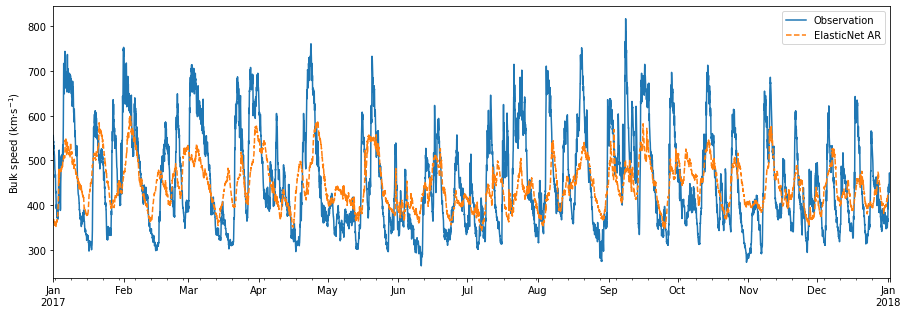

In [50]:
offst = 0
for t in range(len(targets)):
    r = real.loc['2017-01-01':'2018-01-01'].interpolate(method='time')
    r.plot(figsize=(15, 5), title='')
    p = pd.DataFrame(pred, index=y_test.index, columns=['V'])
    p = p.reindex(r.index)
    p['V'].plot(style='--', title='')
    plt.title('')
    plt.suptitle('')
    plt.xlabel('')
    plt.ylabel('Bulk speed (km$\cdot$s$^{-1}$)')
    plt.legend(['Observation', 'ElasticNet AR'])
    plt.show()
    plt.close()

### Model equation extraction

Retrieve obtained formula from the model, and preent it using SymPy.

In [ ]:
import sympy as sp

In [ ]:
correspondences = {
    'height': 'h',
    'lower_loc': 'l',
    'upper_loc': 'u',
    'mag_flux': '\\phi',
    'mag_skewness': '\\eta',
    'last_V': 'V_t-1',
    'last_N': '\\rho_t-1',
    'last_T': 'T_t-1',
    'last_log_T': '\log_10 T_t-1',
    'last_Br': 'B_R_t-1',
    'last_Bt': 'B_T_t-1',
    'last_Bn': 'B_N_t-1',
    'V': 'V_t',
    'N': '\\rho_t',
    'T': 'T_t',
    'BT': 'B_T',
    'BR': 'B_R',
    'BN': 'B_N', 
}

In [ ]:
def parse_name(n):
    new = n.split('-')
    return new[0]+f'_t-{new[1]}'

In [ ]:
expressions = {}
for t in range(len(targets)):
    symb_expr = ''
    for s in model.feature_names_in_:
        try:
            symb_expr += correspondences[s]+' '
        except:
            symb_expr += parse_name(s)+' '
    symbols = sp.symbols(symb_expr)
    coefs = []
    try:
        len(coefs)
        vector = True
        mcoefs = model.coef_[t]
    except:
        vector = False
        mcoefs = model.coef_
    for i in range(len(mcoefs)):
        coefs.append(round(mcoefs[i], 4)*symbols[i])
    expr = coefs[0]
    for c in coefs[1:]:
        expr += c
    if vector:
        expr += model.intercept_[t]
    else:
        expr += model.intercept_
    expressions[targets[t]] = expr

In [ ]:
expressions

In [ ]:
for s, exp in expressions.items():
    display(sp.Eq(sp.symbols(correspondences[s]), exp.simplify()))